<a href="https://colab.research.google.com/github/mkierczak/autoencoders_workshop/blob/main/PCA2VAE_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

First, we need to import appropriate libraries that we will use throughout the workshop.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.regularizers import l1
from matplotlib import pyplot as plt
from keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

# Data

We will be working on a dataset, I have created from HapMap phase 3 project where a number of individuals have been genotyped that come from different parts of the worlds and from different ethnic backgrounds. For the sake of simplicity, I have randomly selected 5000 autosomal markers that we will be working with and saved them along with phenotype data (biological sex, ethnicity etc.) and a pre-computed genomic kinship matrix in the *hdf5* file format.

If you want to try another dataset, you can go for e.g., data from Lazaridis et. al. [*Genomic insights into the origin of farming in the ancient Near East*](https://www.nature.com/articles/nature19310) 2016. Nature **536**:419-424. I have pre-prepared chr1 markers at call rate of 0.99 and higher.

In [ ]:
# HapMap3 randomly selected 5000 autosomal markers data
!wget -O data.hd5 https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc&dl=1

# Data for chr1 from Lazaridis et al.
#!wget -O data.hd5 https://www.dropbox.com/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.h5?rlkey=xp4nfljz0c2za9ihriletxx3x&dl=1


--2023-09-05 06:44:34--  https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc [following]
--2023-09-05 06:44:35--  https://www.dropbox.com/e/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.h5?rlkey=nz8f9df7tt9n0hrpqg7y19omc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbdbbe6f7a8f7f312c1a338a109.dl.dropboxusercontent.com/cd/0/inline/CDJdchDQIAw1aps46nqVZTQkemc_qW-l1x_-15fHF2vp9nlXEqQSlpwKuBVI20lP0A97JRpsDPWeJJA6hYlXu0dlOp1D0Ifznyo9Nl5gdnXGv6cV2jQqQuTvclqM1P9_fgA/file# [following]
--2023-09-05 06:44:36--  https://ucbdbbe6f7a8f7f312c1a338a109.dl

In [ ]:
# Extract genotypes, phenotypes and genomic kinship matrix from hdf5 file
orig_geno = pd.read_hdf('./data.hd5', key = 'geno')
orig_pheno = pd.read_hdf('./data.hd5', key = 'pheno')
orig_gkin = pd.read_hdf('./data.hd5', key = 'gkin')


In [ ]:
# Let's have a look at the genotypes data
orig_geno.info()
orig_geno.iloc[0:4, 0:4]

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, NA19919 to NA19099
Columns: 5000 entries, rs416967 to rs2806497
dtypes: int64(5000)
memory usage: 45.2+ MB


,NA19919,NA19916,NA19835,NA20282,NA19703,NA19902,NA19901,NA19908,NA19914,NA20287,...,NA18853,NA19173,NA19171,NA19140,NA18859,NA19119,NA18860,NA19207,NA19103,NA19099
NA19919,1.000000,0.956045,0.991299,0.998115,0.966539,0.984490,0.969456,0.720372,0.993620,0.987785,...,0.973502,0.976022,0.974834,0.977329,0.977305,0.969765,0.964101,0.984822,0.978650,0.978933
NA19916,0.956045,1.000000,0.987325,0.997055,0.972959,0.988437,0.983771,0.950670,0.987508,0.965180,...,0.979353,0.966666,0.965574,0.972000,0.987989,0.965478,0.984434,0.950259,0.958601,0.971893
NA19835,0.991299,0.987325,1.000000,0.973136,0.974283,0.981403,0.982401,0.978460,0.990013,1.003244,...,0.971275,0.984477,0.967848,0.983973,0.969998,0.979433,0.974723,0.980122,0.988978,0.974627
NA20282,0.998115,0.997055,0.973136,1.000000,0.997064,1.002880,0.989643,0.987173,1.004836,0.977272,...,0.983496,0.988047,0.976974,0.980222,0.975953,0.973370,0.977145,0.984446,0.991740,0.992266


In [ ]:
# Examine phenotypes
orig_pheno.iloc[0:4, ]

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA


In [ ]:
# Look at the genomic kinship matrix
orig_gkin.iloc[0:4, ]

,NA19919,NA19916,NA19835,NA20282,NA19703,NA19902,NA19901,NA19908,NA19914,NA20287,...,NA18853,NA19173,NA19171,NA19140,NA18859,NA19119,NA18860,NA19207,NA19103,NA19099
NA19919,1.000000,0.956045,0.991299,0.998115,0.966539,0.984490,0.969456,0.720372,0.993620,0.987785,...,0.973502,0.976022,0.974834,0.977329,0.977305,0.969765,0.964101,0.984822,0.978650,0.978933
NA19916,0.956045,1.000000,0.987325,0.997055,0.972959,0.988437,0.983771,0.950670,0.987508,0.965180,...,0.979353,0.966666,0.965574,0.972000,0.987989,0.965478,0.984434,0.950259,0.958601,0.971893
NA19835,0.991299,0.987325,1.000000,0.973136,0.974283,0.981403,0.982401,0.978460,0.990013,1.003244,...,0.971275,0.984477,0.967848,0.983973,0.969998,0.979433,0.974723,0.980122,0.988978,0.974627
NA20282,0.998115,0.997055,0.973136,1.000000,0.997064,1.002880,0.989643,0.987173,1.004836,0.977272,...,0.983496,0.988047,0.976974,0.980222,0.975953,0.973370,0.977145,0.984446,0.991740,0.992266


In [ ]:
# Check whether we have missing genotypes in our data
print("Missing genotypes per marker: \n", orig_geno.isna().sum())

Missing genotypes per marker: 
 rs416967      0
rs17013842    0
rs13052452    0
rs11049986    0
rs10994341    0
             ..
rs6557516     0
rs7313246     0
rs317892      0
rs11937009    0
rs2806497     0
Length: 5000, dtype: int64


Since neural networks require numeric values as input, we do not need to do anything -- our genotypes are already encoded as minor allele counts. However, we know that it is best for the networks to get input from the range [0, 1], thus we shall re-code our genotypes so that they are bound between zero and one.

In [ ]:
geno = orig_geno.replace([0, 1.0, 2.0], [0, 0.5, 1.0])
#geno.fillna(0, inplace = True)
#print(geno.isna().sum())
geno


,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


# Training Phase

Now, we will follow some best machine learning practises and randomly split our data into two sets: the training set and the test set. The training set will be used to train our neural network, i.e. to optimize network weights while the latter will be set aside so that it is NEVER used in the training phase. This set will be used to objectively assess performance of our model at the very end.

## Question

Do you think that this random split of the original dataset is good enough?



In [ ]:
train = geno.sample(frac = 0.8, random_state = 42) # 80% of our individuals will go to the training set
test = geno.drop(train.index)
pheno = orig_pheno.set_index(keys = 'id')
train_pheno = pheno[pheno.index.isin(train.index)]
test_pheno = pheno.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Original data:", orig_geno.shape)
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Original data: (1184, 5000)
	 - training set: (947, 5000)
	 - test set: (237, 5000)


# PCA

Before we even start training our autoencoder model, it'd be good to have some benchmark to compare to. Below, we will do a very simple PCA on raw genotypes, not even making use of the kinship matrix.

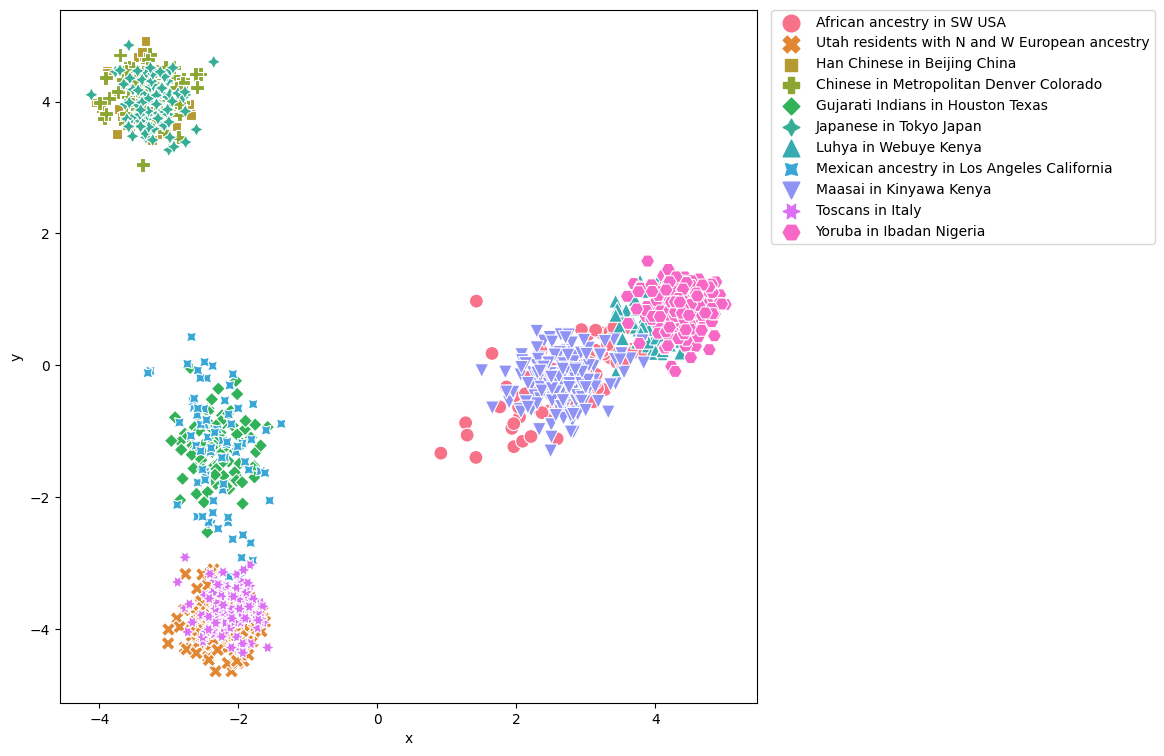

In [ ]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (9,9))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

As you can see, simple PCA separates our individuals into a couple of clear clusters: Africa in the East part of the plot, China and Japa in the NW part and ethnicities of mostly European descent end up in the SW part. While it is easy for PCA to separate Maasai from Yoruba, people of Chinese descent cannot be easily told apart from Japanese using this approach.

In [ ]:
# For Keras framework, we need to convert our data types a bit
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2 # dimentionality of our latent space
print(type(train_tensor))

<class 'numpy.ndarray'>


# Autoencoder Model

Below, we will build our autoencoder model using functional interface provided by the Keras framework. Keras, in turn, will talk to Tensorflow framework that enables us to build, train and use neural networks.

In [176]:
input = keras.Input(shape = (original_dim,))
output = input

h = layers.Dense(units = 1500, activation = 'relu')(input)
h = layers.BatchNormalization()(h)
h = layers.Dropout(rate = 0.05)(h)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
latent = layers.Dense(units = latent_dim, name = 'latent')(h)
encoder = keras.Model(input, latent, name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,))
h = layers.Dense(units = 25, activation = 'relu')(latent_inputs)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 1500, activation = 'relu')(h)
dec_output = layers.Dense(original_dim, activation='sigmoid')(h)
decoder = keras.Model(latent_inputs, dec_output, name='decoder')

output = decoder(encoder(input))
ae_model = keras.Model(input, output, name='AE')

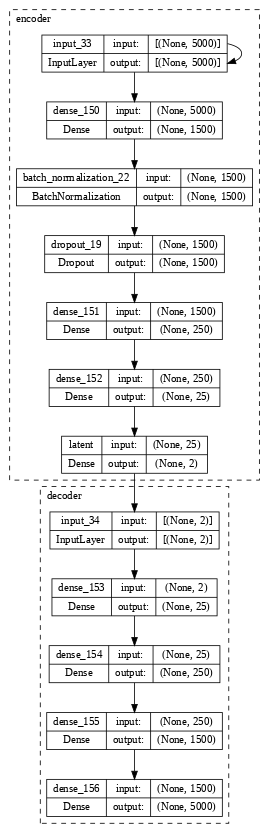

In [179]:
plot_model(ae_model, show_shapes=True, expand_nested = True, dpi=58)

In [200]:
hp_loss_fn = keras.losses.MeanSquaredError()
hp_optimizer = 'adam'
ae_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
)
ae_model.summary(expand_nested = True)

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 5000)]            0         
                                                                 
 encoder (Functional)        (None, 2)                 7889077   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_33 (InputLayer)     [(None, 5000)]            0         |
|                                                               |
| dense_150 (Dense)         (None, 1500)              7501500   |
|                                                               |
| batch_normalization_22 (Bat  (None, 1500)           6000      |
| chNormalization)                                              |
|                                                               |
| dropout_19 (Dropout)      (None, 1500)              0         |
|                                                               

In [209]:
hp_epochs = 30
hp_batch_size = 64
hp_val_split = 0.2

autoencoder = ae_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split
                      )

Epoch 1/30
12/12 [==============================] - 4s 313ms/step - loss: 0.0601 - val_loss: 0.0637
Epoch 2/30
12/12 [==============================] - 3s 259ms/step - loss: 0.0601 - val_loss: 0.0637
Epoch 3/30
12/12 [==============================] - 3s 248ms/step - loss: 0.0602 - val_loss: 0.0638
Epoch 4/30
12/12 [==============================] - 4s 301ms/step - loss: 0.0601 - val_loss: 0.0637
Epoch 5/30
12/12 [==============================] - 3s 282ms/step - loss: 0.0600 - val_loss: 0.0638
Epoch 6/30
12/12 [==============================] - 3s 248ms/step - loss: 0.0600 - val_loss: 0.0638
Epoch 7/30
12/12 [==============================] - 3s 247ms/step - loss: 0.0600 - val_loss: 0.0637
Epoch 8/30
12/12 [==============================] - 4s 308ms/step - loss: 0.0600 - val_loss: 0.0638
Epoch 9/30
12/12 [==============================] - 3s 276ms/step - loss: 0.0599 - val_loss: 0.0639
Epoch 10/30
12/12 [==============================] - 3s 245ms/step - loss: 0.0598 - val_loss: 0.0638

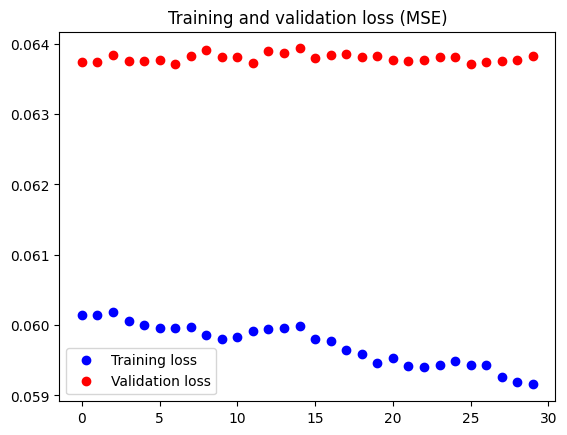

In [210]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.show()

In [211]:
geno_tensor = geno.to_numpy()
geno_dim = geno_tensor.shape[1]
input = keras.Input(shape = (geno_dim,))

trained_encoder = keras.Model(ae_model.input, ae_model.layers[1].get_layer("latent").output)
trained_encoder.summary()


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 5000)]            0         
                                                                 
 dense_150 (Dense)           (None, 1500)              7501500   
                                                                 
 batch_normalization_22 (Bat  (None, 1500)             6000      
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 1500)              0         
                                                                 
 dense_151 (Dense)           (None, 250)               375250    
                                                                 
 dense_152 (Dense)           (None, 25)                6275      
                                                          

37/37 [==============================] - 1s 22ms/step
[[38.604725   6.3760567]
 [17.001957   5.47978  ]
 [17.80107    4.3342857]
 ...
 [21.892857  10.909196 ]
 [20.466078  11.274969 ]
 [18.722141   9.953006 ]]


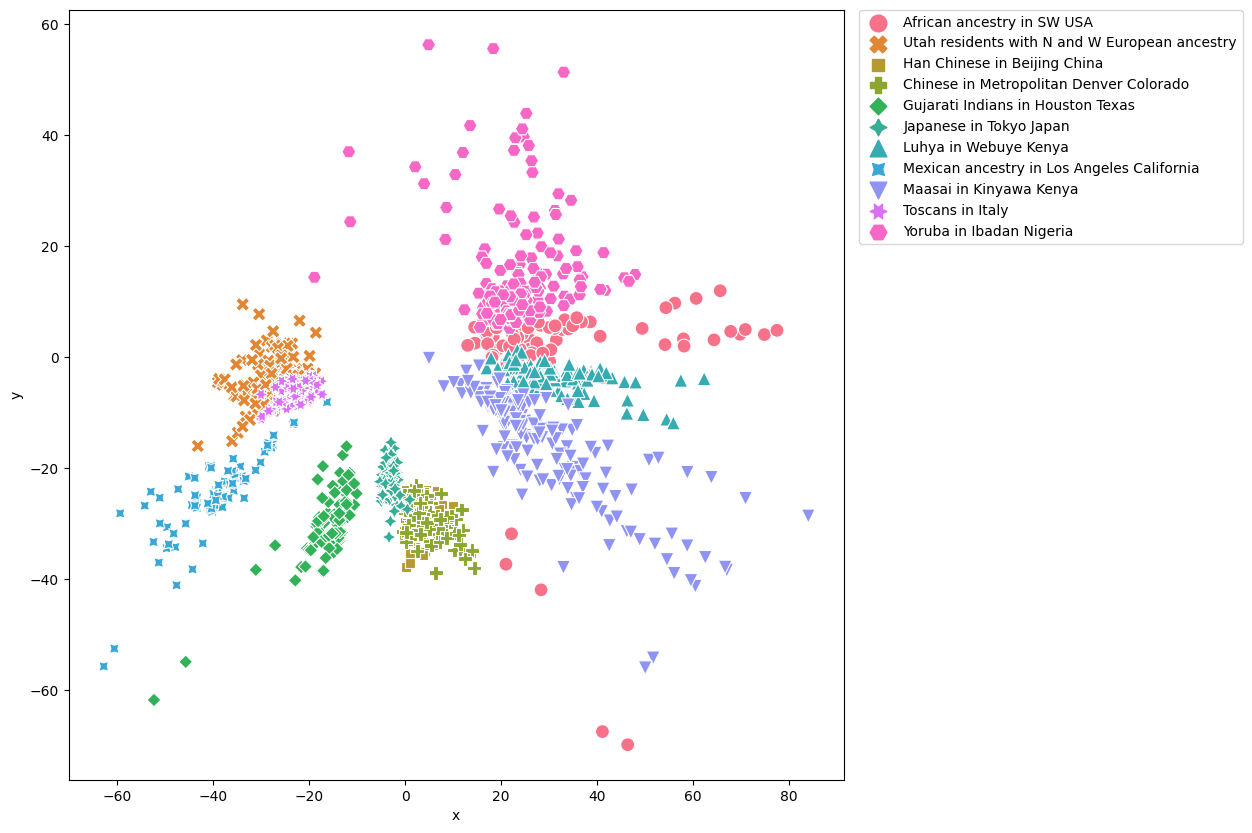

In [212]:
embedded_points = trained_encoder.predict(geno_tensor)
print(embedded_points)

x = embedded_points[:,0]
y = embedded_points[:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# Encoder
input = keras.Input(shape = (original_dim,))

h = layers.Dense(units = 1500, activation = 'relu')(input)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 250, activation = 'relu')(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
# Bottleneck
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
z = layers.Lambda(sampling, name='sampling_layer')([z_mean, z_log_sigma])
encoder = keras.Model(input, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(units = 25, activation = 'relu')(latent_inputs)
x = layers.Dense(units = 250, activation = 'relu')(x)
x = layers.Dense(units = 1500, activation = 'relu')(x)
dec_output = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, dec_output, name='decoder')

# instantiate VAE model
output = decoder(encoder(input)[2])
vae_model = keras.Model(input, output, name='VAE')

In [ ]:
reconstruction_loss = original_dim * keras.losses.mse(input, output)  # use MSE
KL_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(reconstruction_loss + KL_loss)
vae_model.add_loss(vae_loss)
vae_model.compile(optimizer='adam')

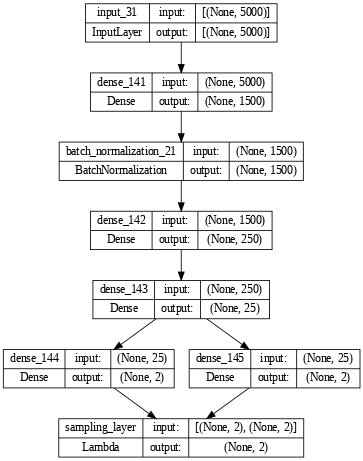

In [ ]:
plot_model(encoder, show_shapes=True, show_layer_names = True, dpi = 60)

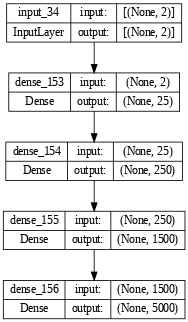

In [214]:
plot_model(decoder, show_shapes=True, expand_nested = True, dpi = 60)

In [ ]:
hp_epochs = 30
hp_batch_size = 32
hp_val_split = 0.2

vae_model.fit(train_tensor, train_tensor,
        epochs = hp_epochs,
        batch_size = hp_batch_size,
        shuffle = True,
        validation_split = hp_val_split)

Epoch 1/30
24/24 [==============================] - 8s 228ms/step - loss: 495.5819 - val_loss: 11541.3154
Epoch 2/30
24/24 [==============================] - 6s 266ms/step - loss: 369.0539 - val_loss: 355.4991
Epoch 3/30
24/24 [==============================] - 5s 221ms/step - loss: 344.8892 - val_loss: 339.4262
Epoch 4/30
24/24 [==============================] - 6s 263ms/step - loss: 333.8501 - val_loss: 332.0295
Epoch 5/30
24/24 [==============================] - 5s 216ms/step - loss: 327.2937 - val_loss: 328.1033
Epoch 6/30
24/24 [==============================] - 6s 251ms/step - loss: 324.9713 - val_loss: 326.3216
Epoch 7/30
24/24 [==============================] - 6s 231ms/step - loss: 324.0119 - val_loss: 325.7481
Epoch 8/30
24/24 [==============================] - 5s 217ms/step - loss: 324.0067 - val_loss: 325.4170
Epoch 9/30
24/24 [==============================] - 6s 262ms/step - loss: 323.4852 - val_loss: 325.6118
Epoch 10/30
24/24 [==============================] - 5s 218ms/

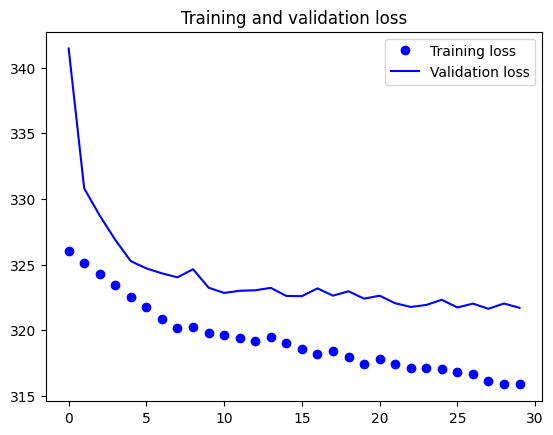

In [ ]:
loss = vae_model.history.history['loss']
val_loss = vae_model.history.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

37/37 [==============================] - 1s 21ms/step
[array([[ 0.10946293,  1.6379908 ],
       [-0.19524507,  0.84827495],
       [-0.35888317,  0.7927902 ],
       ...,
       [-0.02947776,  1.3002853 ],
       [ 0.13081308,  1.3805043 ],
       [-0.27376977,  1.3217776 ]], dtype=float32), array([[-2.3427675, -1.8056066],
       [-1.9156632, -1.4490807],
       [-1.8786201, -1.2377045],
       ...,
       [-1.8776844, -1.8033681],
       [-2.3057938, -1.8459293],
       [-1.9712316, -1.5221589]], dtype=float32), array([[ 0.0034585 ,  1.6979836 ],
       [-0.07620627,  0.72215927],
       [-0.5617876 ,  0.52854836],
       ...,
       [ 0.17412204,  1.5514481 ],
       [ 0.08474161,  1.3682321 ],
       [-0.09462763,  1.1295272 ]], dtype=float32)]


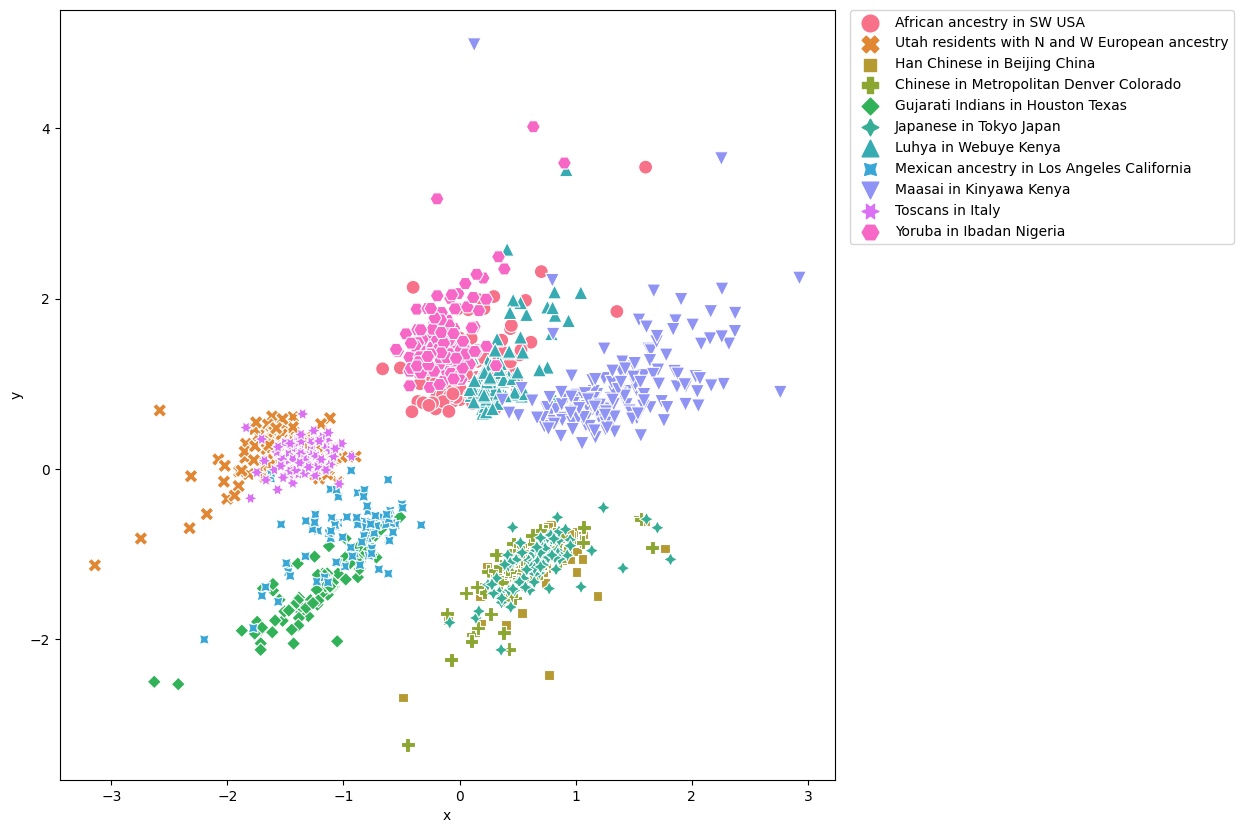

In [122]:
embedded_points = encoder.predict(geno_tensor)
print(embedded_points)

x = embedded_points[0][:,0]
y = embedded_points[0][:,1]
pop = pop
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [162]:
N_ind = 10
center = [-2, -0.5]
cx = K.random_normal(shape = [N_ind], mean = center[0], stddev = 0.1)
cy = K.random_normal(shape = [N_ind], mean = center[1], stddev = 0.1)
z_sample = np.column_stack((cx, cy))
z_sample

array([[-1.7144625 , -0.4996249 ],
       [-2.0686884 , -0.37838784],
       [-2.014274  , -0.5337421 ],
       [-2.0016365 , -0.56499684],
       [-1.9603547 , -0.5029502 ],
       [-1.9330964 , -0.41390002],
       [-1.8245691 , -0.5102214 ],
       [-2.1764903 , -0.66615444],
       [-1.9464548 , -0.53645134],
       [-1.9683152 , -0.6197554 ]], dtype=float32)

In [163]:
decoded = decoder.predict(z_sample,)
decoded

1/1 [==============================] - 0s 31ms/step


array([[0.31774452, 0.15078673, 0.06747469, ..., 0.53459066, 0.35686463,
        0.0154432 ],
       [0.3192935 , 0.15327679, 0.05871284, ..., 0.5438806 , 0.34862107,
        0.01239935],
       [0.32017818, 0.15243828, 0.06240514, ..., 0.5400669 , 0.3522282 ,
        0.01344395],
       ...,
       [0.32189786, 0.15108934, 0.06249202, ..., 0.53918433, 0.3529972 ,
        0.01294818],
       [0.3197197 , 0.15214634, 0.06379729, ..., 0.5388323 , 0.35328346,
        0.01394662],
       [0.3210742 , 0.1513171 , 0.06584131, ..., 0.53604543, 0.35610124,
        0.01427394]], dtype=float32)

In [164]:

new_geno = np.zeros(shape = decoded.shape)
new_geno[decoded <= 0.33] = 0
new_geno[np.logical_and(decoded > 0.33, decoded < 0.66)] = 1
new_geno[decoded > 0.66] = 2
print(new_geno)

[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


38/38 [==============================] - 1s 33ms/step


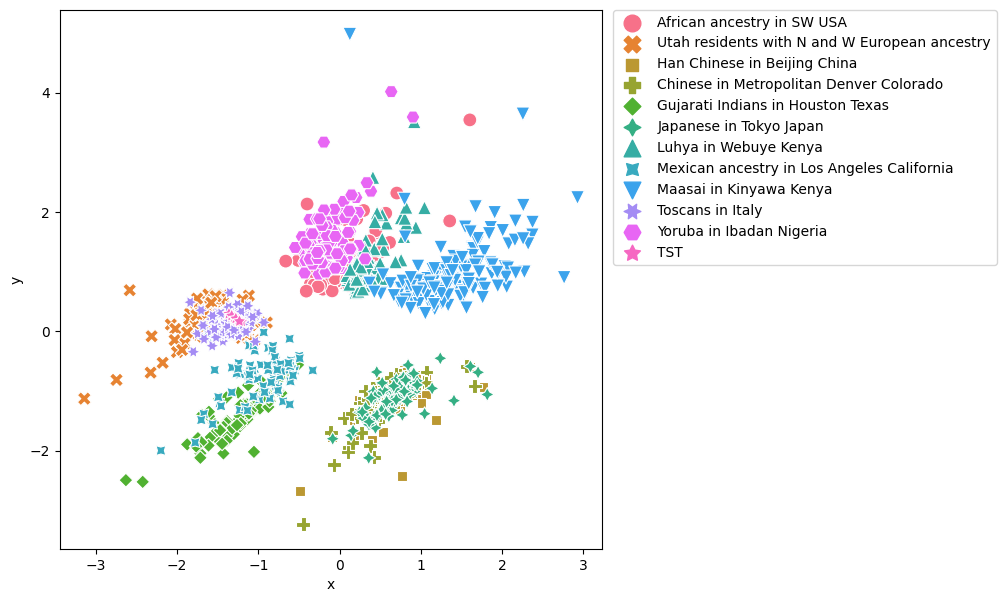

In [165]:
x_encoded = encoder.predict(np.row_stack((geno_tensor, decoded)), batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop_list = [pheno['population'], pd.Series(np.repeat('TST', new_geno.shape[0]))]
pop = pd.concat(pop_list)
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()